In [1]:
import pandas as pd
from pandas import Timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
import os
import optuna
import time
from scipy.stats import randint
import shap
import joblib
from utils import run_kfold, run_kfold_eval, run_kfold_trainonly, feature_selection, calculate_metric

In [2]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/rf'

TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
OOF_PREDICTIONS_FILE = '../output/oof_predictions.xlsx'
SHEET_NAME = "random_forest"
OUTPUT_FILE =  OUTPUT_PATH + '/model.pkl'

Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

In [3]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [4]:
train_features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-1.889878e-04,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,7.683437e-04,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,6.775025e-04,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,1.638489e-03,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,6.638372e-04,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,8.750,307.67380,1.054000e-03,-5.484658,96.677513,67.838623,87.5685,102.028381,136.330704,1.5202,...,False,False,False,False,False,False,False,False,False,False
1289,6.125,491.25588,8.933177e-04,2.005055,98.932098,66.249748,93.9513,100.522171,136.250092,0.0761,...,False,False,False,False,False,False,False,False,False,False
1290,9.000,43.70692,-4.028951e-07,4568.633320,156.256317,122.623718,166.0653,169.132080,206.585861,0.2543,...,True,False,False,False,False,False,False,False,False,False
1291,7.000,121.35372,4.802102e-04,7.101655,120.138161,86.369835,108.8460,128.547882,158.452438,0.5101,...,True,False,False,False,False,False,False,False,False,False


In [5]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 317)
(1293, 1)
(432, 317)
(432, 1)


In [6]:
train_df = train_features.copy()
train_df['rr1_30'] = train_labels

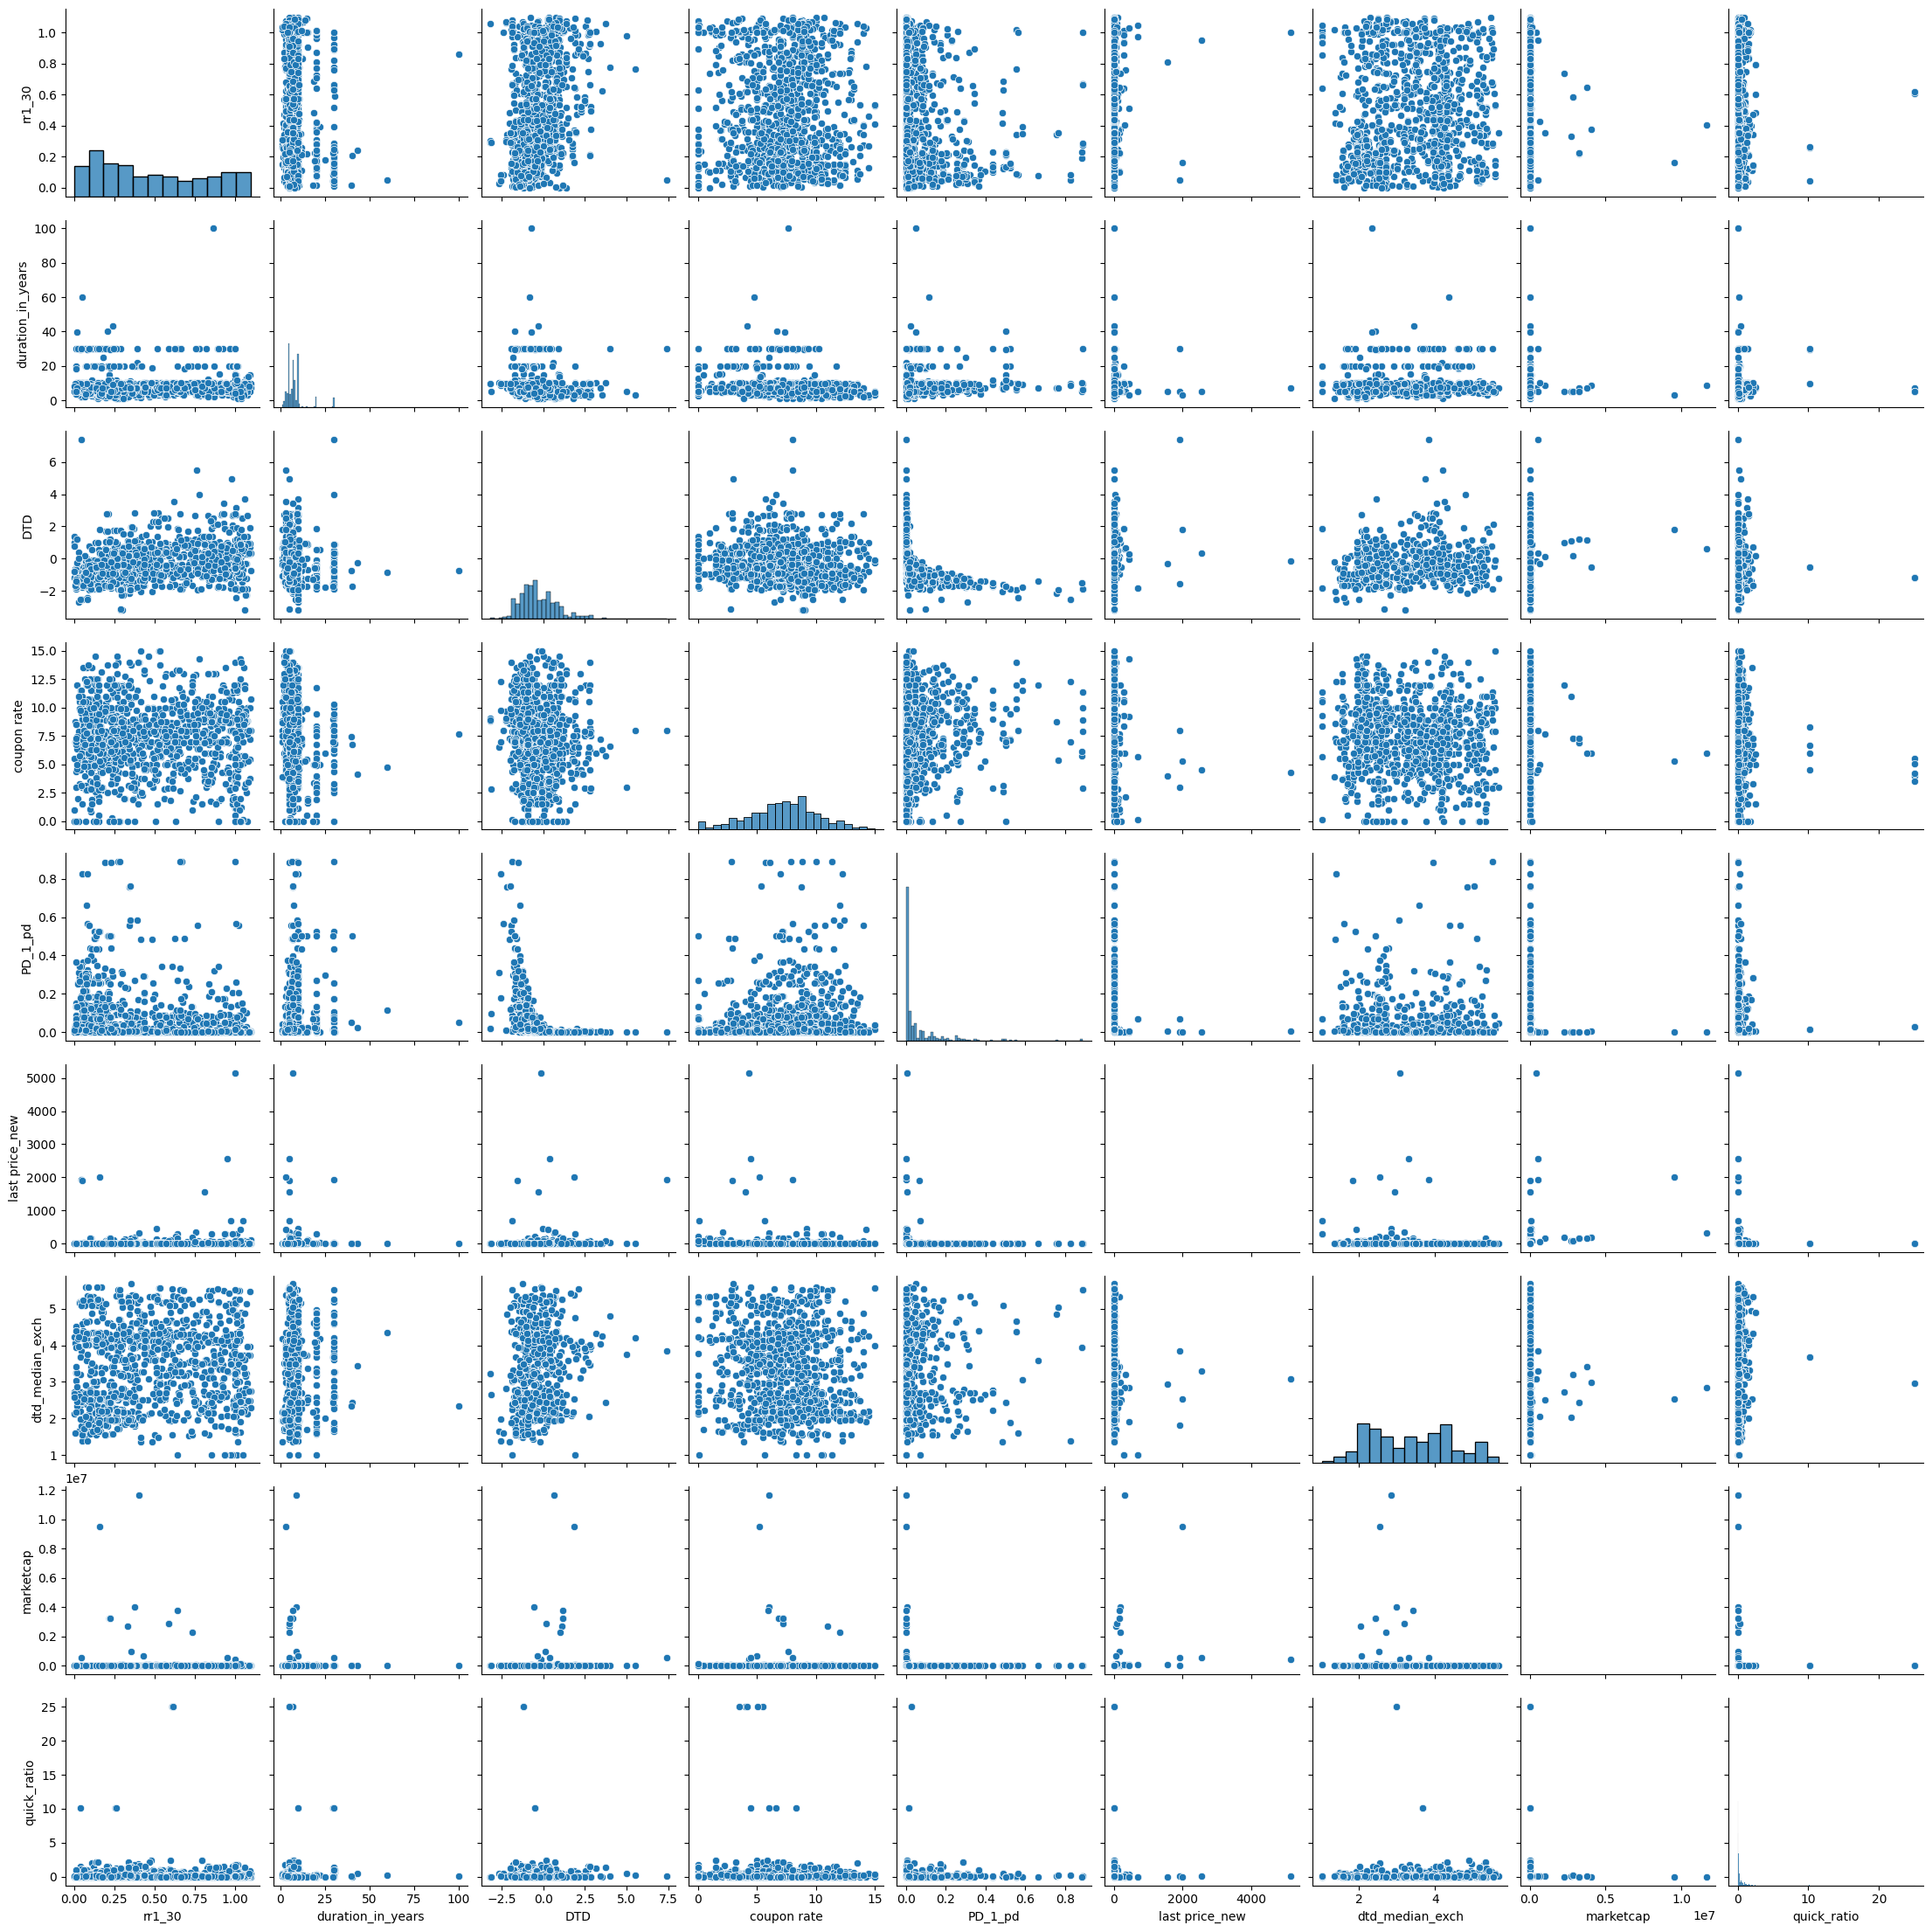

In [7]:

sns.pairplot(train_df[['rr1_30','duration_in_years', 'DTD', 'coupon rate', 'PD_1_pd', 'last price_new', 'dtd_median_exch', 'marketcap', 'quick_ratio']])

In [8]:
features_list = train_features.columns

In [16]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 200, 3000, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    n_jobs=-1
    )
    model.fit(train_x, train_y)

    # Make predictions and calculate RMSE
    predictions = model.predict(valid_x)
    mae, mape, rmse, rsqr = calculate_metric(predictions, valid_y.to_numpy())

    # Return MAE
    return rmse


In [17]:
# Create study object
study = optuna.create_study(direction="minimize")

# Run optimization process
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-19 12:56:29,462] A new study created in memory with name: no-name-8f548206-f9b0-494f-b5ad-f94007d8a3d0
  0%|          | 0/50 [00:00<?, ?it/s]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
Best trial: 0. Best value: 0.255588:   2%|▏         | 1/50 [00:05<04:14,  5.18s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:56:34,648] Trial 0 finished with value: 0.2555880107935944 and parameters: {'n_estimators': 454, 'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.2555880107935944.


Best trial: 1. Best value: 0.241267:   4%|▍         | 2/50 [00:24<10:45, 13.44s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:56:53,872] Trial 1 finished with value: 0.24126743413678386 and parameters: {'n_estimators': 1194, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.24126743413678386.


Best trial: 1. Best value: 0.241267:   6%|▌         | 3/50 [00:27<06:57,  8.88s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:56:57,312] Trial 2 finished with value: 0.25713633123685675 and parameters: {'n_estimators': 264, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.24126743413678386.


Best trial: 3. Best value: 0.237903:   8%|▊         | 4/50 [00:50<11:02, 14.41s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:57:20,199] Trial 3 finished with value: 0.2379026195559383 and parameters: {'n_estimators': 1413, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 3. Best value: 0.237903:  10%|█         | 5/50 [01:16<13:57, 18.62s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:57:46,283] Trial 4 finished with value: 0.2697502384473653 and parameters: {'n_estimators': 2872, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 3. Best value: 0.237903:  12%|█▏        | 6/50 [01:52<17:56, 24.47s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:58:22,113] Trial 5 finished with value: 0.2532416157566983 and parameters: {'n_estimators': 2688, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 3. Best value: 0.237903:  14%|█▍        | 7/50 [01:54<12:15, 17.10s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:58:24,046] Trial 6 finished with value: 0.28957788576359317 and parameters: {'n_estimators': 319, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 3. Best value: 0.237903:  16%|█▌        | 8/50 [01:58<09:02, 12.92s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:58:27,995] Trial 7 finished with value: 0.24291805156079221 and parameters: {'n_estimators': 258, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 3. Best value: 0.237903:  18%|█▊        | 9/50 [02:01<06:38,  9.72s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:58:30,676] Trial 8 finished with value: 0.25831914737658107 and parameters: {'n_estimators': 241, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 3. Best value: 0.237903:  20%|██        | 10/50 [02:34<11:13, 16.85s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:59:03,495] Trial 9 finished with value: 0.24512442996878425 and parameters: {'n_estimators': 2368, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.2379026195559383.


Best trial: 10. Best value: 0.233971:  22%|██▏       | 11/50 [02:56<12:01, 18.50s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:59:25,741] Trial 10 finished with value: 0.23397109034055258 and parameters: {'n_estimators': 1087, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.23397109034055258.


Best trial: 10. Best value: 0.233971:  24%|██▍       | 12/50 [03:17<12:12, 19.27s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 12:59:46,768] Trial 11 finished with value: 0.23400038441355353 and parameters: {'n_estimators': 1110, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.23397109034055258.


Best trial: 12. Best value: 0.233918:  26%|██▌       | 13/50 [03:31<11:01, 17.88s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:00:01,449] Trial 12 finished with value: 0.23391786498735992 and parameters: {'n_estimators': 741, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.23391786498735992.


Best trial: 12. Best value: 0.233918:  28%|██▊       | 14/50 [03:40<08:59, 14.99s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:00:09,771] Trial 13 finished with value: 0.2473540497888692 and parameters: {'n_estimators': 582, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.23391786498735992.


Best trial: 14. Best value: 0.233903:  30%|███       | 15/50 [03:56<08:58, 15.37s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:00:26,022] Trial 14 finished with value: 0.23390310012225365 and parameters: {'n_estimators': 797, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  32%|███▏      | 16/50 [04:06<07:42, 13.61s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:00:35,536] Trial 15 finished with value: 0.24367792208878028 and parameters: {'n_estimators': 707, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  34%|███▍      | 17/50 [04:13<06:27, 11.73s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:00:42,893] Trial 16 finished with value: 0.2506622302331748 and parameters: {'n_estimators': 466, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  36%|███▌      | 18/50 [04:38<08:27, 15.87s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:01:08,412] Trial 17 finished with value: 0.24331294617596166 and parameters: {'n_estimators': 1732, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  38%|███▊      | 19/50 [04:53<08:02, 15.57s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:01:23,273] Trial 18 finished with value: 0.2352262682117968 and parameters: {'n_estimators': 883, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  40%|████      | 20/50 [05:07<07:30, 15.03s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:01:37,056] Trial 19 finished with value: 0.2387111102194774 and parameters: {'n_estimators': 762, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  42%|████▏     | 21/50 [05:13<06:00, 12.43s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:01:43,421] Trial 20 finished with value: 0.2475314194420745 and parameters: {'n_estimators': 429, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  44%|████▍     | 22/50 [05:33<06:45, 14.49s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:02:02,709] Trial 21 finished with value: 0.23398589309333054 and parameters: {'n_estimators': 956, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 14. Best value: 0.233903:  46%|████▌     | 23/50 [05:58<08:01, 17.82s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:02:28,308] Trial 22 finished with value: 0.24084226532638425 and parameters: {'n_estimators': 1550, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.23390310012225365.


Best trial: 23. Best value: 0.233533:  48%|████▊     | 24/50 [06:11<07:03, 16.31s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:02:41,074] Trial 23 finished with value: 0.23353304011388548 and parameters: {'n_estimators': 597, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  50%|█████     | 25/50 [06:22<06:06, 14.64s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:02:51,832] Trial 24 finished with value: 0.23678066811042092 and parameters: {'n_estimators': 584, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  52%|█████▏    | 26/50 [06:33<05:27, 13.65s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:03:03,161] Trial 25 finished with value: 0.23464306470350837 and parameters: {'n_estimators': 655, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  54%|█████▍    | 27/50 [06:38<04:15, 11.10s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:03:08,328] Trial 26 finished with value: 0.24449164981486168 and parameters: {'n_estimators': 340, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  56%|█████▌    | 28/50 [06:49<03:59, 10.87s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:03:18,652] Trial 27 finished with value: 0.2405557749410103 and parameters: {'n_estimators': 544, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  58%|█████▊    | 29/50 [06:59<03:47, 10.83s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:03:29,375] Trial 28 finished with value: 0.2479664605509373 and parameters: {'n_estimators': 901, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  60%|██████    | 30/50 [07:06<03:12,  9.62s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:03:36,185] Trial 29 finished with value: 0.23645523985083458 and parameters: {'n_estimators': 426, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  62%|██████▏   | 31/50 [07:10<02:28,  7.84s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:03:39,869] Trial 30 finished with value: 0.2388025496964032 and parameters: {'n_estimators': 204, 'max_depth': 31, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  64%|██████▍   | 32/50 [07:30<03:28, 11.59s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:04:00,218] Trial 31 finished with value: 0.23401268946779394 and parameters: {'n_estimators': 1117, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  66%|██████▌   | 33/50 [07:55<04:24, 15.54s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:04:24,956] Trial 32 finished with value: 0.2340301382998313 and parameters: {'n_estimators': 1325, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  68%|██████▊   | 34/50 [08:06<03:48, 14.26s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:04:36,242] Trial 33 finished with value: 0.24078952015309213 and parameters: {'n_estimators': 830, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  70%|███████   | 35/50 [08:17<03:16, 13.12s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:04:46,694] Trial 34 finished with value: 0.23706447549711018 and parameters: {'n_estimators': 670, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  72%|███████▏  | 36/50 [08:34<03:20, 14.35s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:05:03,926] Trial 35 finished with value: 0.23453554802474066 and parameters: {'n_estimators': 1007, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  74%|███████▍  | 37/50 [09:01<03:57, 18.30s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:05:31,453] Trial 36 finished with value: 0.237431892895544 and parameters: {'n_estimators': 1886, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  76%|███████▌  | 38/50 [09:08<02:56, 14.71s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:05:37,784] Trial 37 finished with value: 0.24063341967347027 and parameters: {'n_estimators': 486, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  78%|███████▊  | 39/50 [09:21<02:36, 14.26s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:05:50,972] Trial 38 finished with value: 0.2531645526930475 and parameters: {'n_estimators': 1263, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  80%|████████  | 40/50 [09:26<01:55, 11.54s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:05:56,162] Trial 39 finished with value: 0.2379513698707872 and parameters: {'n_estimators': 358, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  82%|████████▏ | 41/50 [09:42<01:54, 12.74s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:06:11,716] Trial 40 finished with value: 0.23742298192130434 and parameters: {'n_estimators': 790, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  84%|████████▍ | 42/50 [10:03<02:02, 15.33s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:06:33,099] Trial 41 finished with value: 0.23392165236779355 and parameters: {'n_estimators': 984, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  86%|████████▌ | 43/50 [10:26<02:04, 17.71s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:06:56,368] Trial 42 finished with value: 0.23389121503398963 and parameters: {'n_estimators': 1100, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  88%|████████▊ | 44/50 [10:53<02:02, 20.35s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:07:22,859] Trial 43 finished with value: 0.23730177261275034 and parameters: {'n_estimators': 1490, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  90%|█████████ | 45/50 [11:06<01:31, 18.30s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:07:36,367] Trial 44 finished with value: 0.23368107542795574 and parameters: {'n_estimators': 732, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  92%|█████████▏| 46/50 [11:18<01:05, 16.26s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:07:47,866] Trial 45 finished with value: 0.2368218986124101 and parameters: {'n_estimators': 600, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  94%|█████████▍| 47/50 [11:27<00:42, 14.01s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:07:56,632] Trial 46 finished with value: 0.2591026843675796 and parameters: {'n_estimators': 731, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  96%|█████████▌| 48/50 [11:33<00:23, 11.63s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:08:02,705] Trial 47 finished with value: 0.25698721309965106 and parameters: {'n_estimators': 504, 'max_depth': 31, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533:  98%|█████████▊| 49/50 [11:47<00:12, 12.45s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[I 2024-08-19 13:08:17,072] Trial 48 finished with value: 0.2336755444237924 and parameters: {'n_estimators': 673, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.23353304011388548.


Best trial: 23. Best value: 0.233533: 100%|██████████| 50/50 [11:53<00:00, 14.27s/it]

[I 2024-08-19 13:08:22,972] Trial 49 finished with value: 0.24216773431470434 and parameters: {'n_estimators': 388, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.23353304011388548.
Number of finished trials:  50
Best trial:
  Value: 0.23353304011388548
  Params: 
    n_estimators: 597
    max_depth: 32
    min_samples_split: 2
    min_samples_leaf: 1


In [18]:
trial.params

{'n_estimators': 597,
 'max_depth': 32,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

In [9]:
# best_params = trial.params
best_params = {'n_estimators': 597,
 'max_depth': 32,
 'min_samples_split': 2,
 'min_samples_leaf': 1}
model_args = {"random_state": 42, "n_jobs": -1, **best_params}

In [9]:
start_time = time.time()

# Instantiate model
rf = RandomForestRegressor(**model_args)
# Train the model on training data
rf.fit(train_features, train_labels)

# print out training time
elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training time: 22.426 seconds


In [10]:
# Use the forest's predict method on the test data
train_predictions = rf.predict(train_features)

mae, mape, rmse, rsqr = calculate_metric(train_predictions, train_labels.to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.3521148387265957
Val average mean absolute percentage error: 4652.4198782122
Val average root mean squared error: 0.08551619900522284
Val average R2: 0.9325910463968649


In [11]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels.to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.3438405175097586
Val average mean absolute percentage error: 391.5313069139195
Val average root mean squared error: 0.2213111362538438
Val average R2: 0.572403425074414


In [15]:
# save train predictions
import joblib


train_predictions_df = pd.DataFrame({"predictions": train_predictions})
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
test_predictions_df = pd.DataFrame({"predictions": predictions})
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    test_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(rf, OUTPUT_FILE)

['../output/rf/model.pkl']

In [14]:
# Calculate the depth of each tree
depths = [tree.tree_.max_depth for tree in rf.estimators_]

# Calculate the average depth
average_depth = np.mean(depths)

print(f'Average depth: ', average_depth)

Average depth:  27.105527638190956


In [15]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': features_list,
    'Importance': rf.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

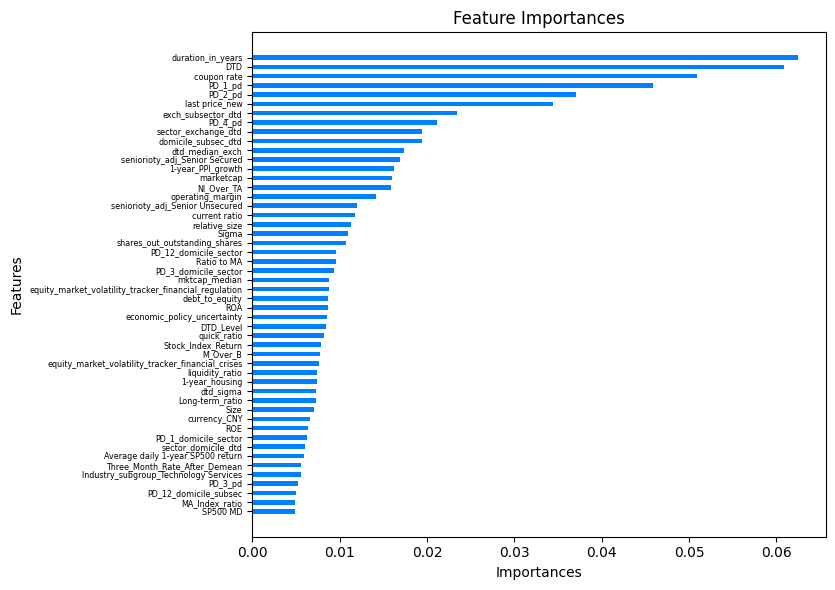

In [19]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'].tail(50), feature_importances['Importance'].tail(50), color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'rf_feature_importance.png'))

plt.show()

SHAP

SHAP on training set

In [21]:
# standardize train features first
train_ft_scaled_df = pd.DataFrame(data=train_features, columns=train_features.columns)

explainer = shap.TreeExplainer(rf)
explanation = explainer(train_features)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - train_predictions).max()

9.71445146547012e-13

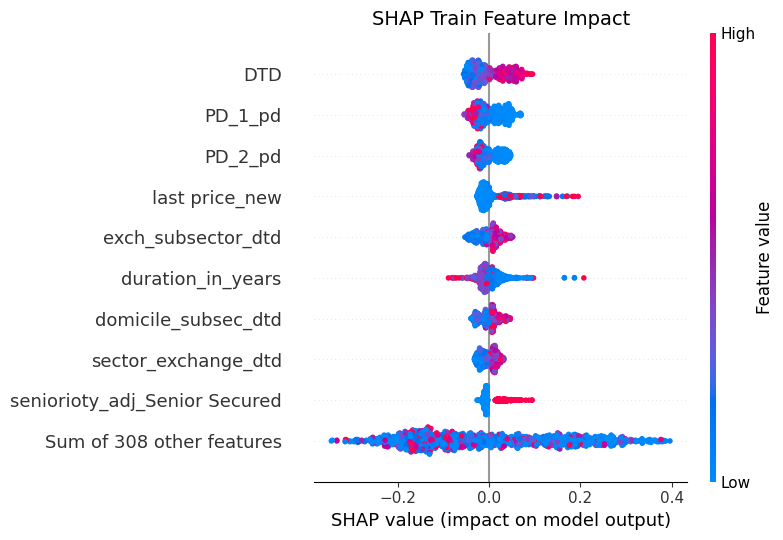

In [22]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # Adjust size as needed
# Create the beeswarm plot
shap.plots.beeswarm(explanation, show=False)  # Set show=False to prevent automatic display
# Add title if desired
plt.title("SHAP Train Feature Impact", fontsize=14)
plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/shap_train_feature_beeswarm.png')
plt.show()

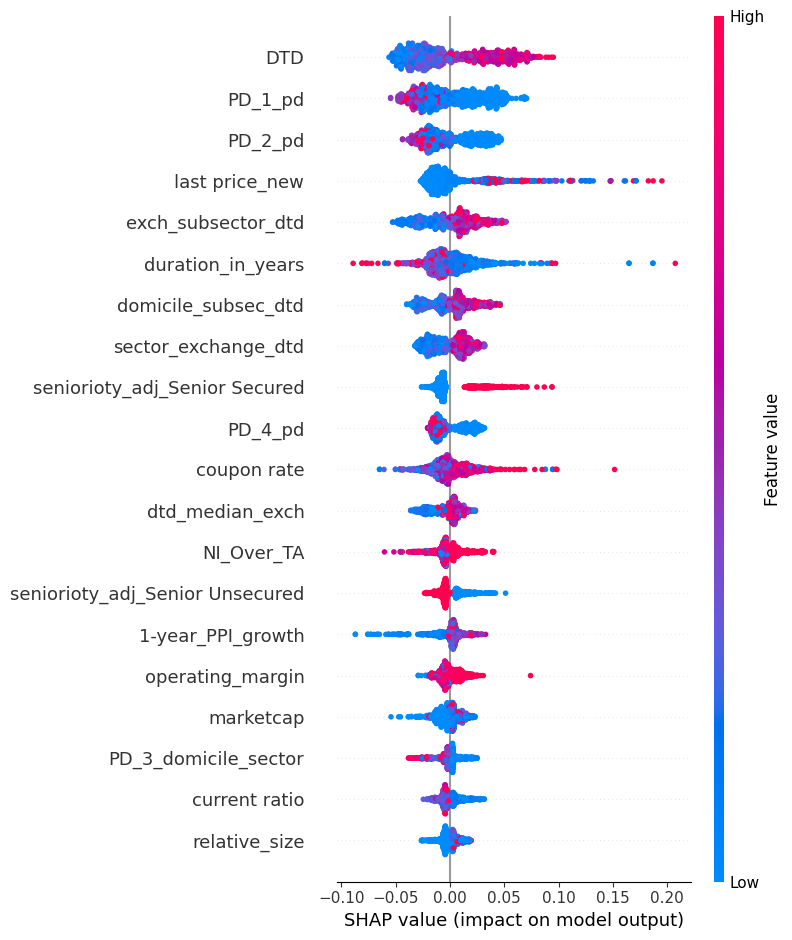

In [23]:
shap.summary_plot(shap_values, train_features)

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(train_features)
print(f"shape: ", shap_interaction_values.shape)

5-fold CV

In [61]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [62]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [75]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features.to_numpy(), labels.to_numpy(), n_folds=5, model=RandomForestRegressor, model_params=model_args, output_path=OUTPUT_PATH, name="rf_model")

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
 20%|██        | 1/5 [00:11<00:45, 11.35s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
 40%|████      | 2/5 [00:27<00:41, 13.93s/it]/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionW

In [77]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3401610289831122
Test average mean absolute percentage error: 3623.2099757730566
Test average root mean squared error: 0.21179143264461295
Test average R2: 0.5899574805901407


Random search of hyperparameters

In [81]:
# Define the hyperparameter distribution
param_dist = {
    'n_estimators': randint(200, 3000),
    'max_depth': randint(2, 32),
    'min_samples_split': randint(2, 10),
    "min_samples_leaf": randint(1, 10)
}

model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV to the data
random_search.fit(train_features, train_labels)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: ", random_search.best_score_)

/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Best parameters found:  {'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1282}
Best cross-validation accuracy:  -0.23792547281035725


In [82]:
# Evaluate on the test set
best_model = random_search.best_estimator_
predictions = best_model.predict(test_features)

mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels.to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")


Val average mean absolute error: 0.34304324801057023
Val average mean absolute percentage error: 391.73403555040716
Val average root mean squared error: 0.22305448428969316
Val average R2: 0.5656402250815031


5-fold CV

In [87]:
model_args = random_search.best_estimator_.get_params()

In [89]:
model_args

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 26,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1282,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [90]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features.to_numpy(), labels.to_numpy(), n_folds=5, model=RandomForestRegressor, model_params=model_args, output_path=OUTPUT_PATH, name="rf_model", save_dir=OUTPUT_PATH)

/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/hoanguyen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Recovery rate forecasting/.venv312/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

In [91]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.339191968401262
Test average mean absolute percentage error: 3622.1109125705943
Test average root mean squared error: 0.21314964465062608
Test average R2: 0.5844148595002974


SAVING OUT-OF-PREDICTION RESULTS

In [10]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(train_features.to_numpy(), train_labels.to_numpy(), n_folds=5, model=RandomForestRegressor, model_params=model_args, output_path=OUTPUT_PATH, name="rf_model", saving_model=False)

  0%|          | 0/5 [00:00<?, ?it/s]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 20%|██        | 1/5 [00:02<00:10,  2.55s/it]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
 40%|████      | 2/5 [00:04<00:06,  2.31s/it]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]/home/nguyenhoa/miniconda3/envs/.henv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args,

In [11]:
oof_predictions_df = pd.DataFrame({"predictions": oof_preds.ravel()})
with pd.ExcelWriter(OOF_PREDICTIONS_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    oof_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)